In [ ]:
!pip install timm
!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 4.2 MB/s 
     |████████████████████████████████| 163 kB 35.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187.4 MB 21 kB/s 
     |████████████████████████████████| 776.3 MB 17 kB/s 
     |████████████████████████████████| 57 kB 4.9 MB/s 
     |████████████████████████████████| 115 kB 53.8 MB/s 
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.8.2
    Uninstalling google-api-core-2.8.2:
      Successfully uninstalled google-api-core-2.8.2
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: torch
    Found

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

KeyError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# For parallelization in TPUs
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/CS4641Project/data"
TRAIN_PATH = "/content/drive/MyDrive/CS4641Project/data/train_images"
TEST_PATH = "/content/drive/MyDrive/CS4641Project/data/test_images"
MODEL_PATH = (
    "/content/drive/MyDrive/CS4641Project/vit_base_p16_224.pth"
)

# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 10

In [ ]:
disease_types=['COVID', 'non-COVID']
train_dir = os.path.join(DATA_PATH)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id])
        
df = pd.DataFrame(train_data, columns=['image_id', 'label'])
df.head

<bound method NDFrame.head of                             image_id  label
0             COVID/Covid (1241).png      0
1             COVID/Covid (1246).png      0
2              COVID/Covid (165).png      0
3               COVID/Covid (26).png      0
4             COVID/Covid (1248).png      0
...                              ...    ...
2477  non-COVID/Non-Covid (1188).png      1
2478  non-COVID/Non-Covid (1164).png      1
2479  non-COVID/Non-Covid (1154).png      1
2480  non-COVID/Non-Covid (1044).png      1
2481   non-COVID/Non-Covid (115).png      1

[2482 rows x 2 columns]>

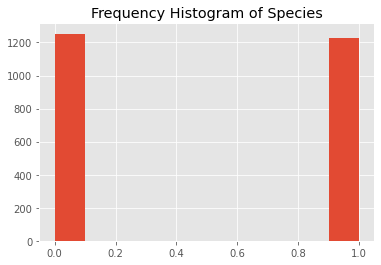

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.hist(df['label'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [ ]:
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=42, stratify=df.label.values
)

In [ ]:
class CovidDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = ""
        # self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [ ]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

In [ ]:
class ViTBase16(nn.Module):
  def __init__(self, n_classes, pretrained=False):

    super(ViTBase16, self).__init__()

    self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
    if pretrained:
      self.model.load_state_dict(torch.load(MODEL_PATH))

    self.model.head = nn.Linear(self.model.head.in_features, n_classes)
    self.history = {
        "train_loss": [],
        "valid_loss": [],
        "train_acc": [],
        "valid_acc": [],
    }

  def forward(self, x):
    x = self.model(x)
    return x

  def train_one_epoch(self, train_loader, criterion, optimizer, device):
    # keep track of training loss
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    ###################
    # train the model #
    ###################
    self.model.train()
    for i, (data, target) in enumerate(train_loader):
      # move tensors to GPU if CUDA is available
      if device.type == "cuda":
        data, target = data.cuda(), target.cuda()
      elif device.type == "xla":
        data = data.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.int64)

      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = self.forward(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Calculate Accuracy
      accuracy = (output.argmax(dim=1) == target).float().mean()
      # update training loss and accuracy
      epoch_loss += loss
      epoch_accuracy += accuracy

      # perform a single optimization step (parameter update)
      if device.type == "xla":
        xm.optimizer_step(optimizer)

        if i % 20 == 0:
          xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

      else:
        optimizer.step()

    return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

  def validate_one_epoch(self, valid_loader, criterion, device):
    # keep track of validation loss
    valid_loss = 0.0
    valid_accuracy = 0.0

    ######################
    # validate the model #
    ######################
    self.model.eval()
    for data, target in valid_loader:
      # move tensors to GPU if CUDA is available
      if device.type == "cuda":
        data, target = data.cuda(), target.cuda()
      elif device.type == "xla":
        data = data.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.int64)

      with torch.no_grad():
        # forward pass: compute predicted outputs by passing inputs to the model
        output = self.model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # Calculate Accuracy
        accuracy = (output.argmax(dim=1) == target).float().mean()
        # update average validation loss and accuracy
        valid_loss += loss
        valid_accuracy += accuracy

    return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        model.history["train_loss"].append(train_loss.item())
        model.history["train_acc"].append(train_acc.item())
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()


        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            model.history["valid_loss"].append(valid_loss.item())
            model.history["valid_acc"].append(valid_acc.item())
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            #                 xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_loss": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [ ]:
model = ViTBase16(n_classes=2, pretrained=False)
model


ViTBase16(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072, out_

In [ ]:
def _run():
    train_dataset = CovidDataset(train_df, transforms=transforms_train)
    valid_dataset = CovidDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()
    #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
  torch.set_default_tensor_type("torch.FloatTensor")
  logs = _run()


# _run()
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method="fork")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


INITIALIZING TRAINING ON 8 TPU CORES
Start Time: 2022-11-13 13:51:25.200236
EPOCH 1 - TRAINING...
	BATCH 1/15 - LOSS: 0.67578125


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: 


	[TRAIN] EPOCH 1 - LOSS: 1.03125, ACCURACY: 0.5390625

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.78125, ACCURACY: 0.396484375

EPOCH 2 - TRAINING...
	BATCH 1/15 - LOSS: 0.66015625

	[TRAIN] EPOCH 2 - LOSS: 0.63671875, ACCURACY: 0.6328125

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.796875, ACCURACY: 0.396484375

EPOCH 3 - TRAINING...
	BATCH 1/15 - LOSS: 0.609375

	[TRAIN] EPOCH 3 - LOSS: 0.61328125, ACCURACY: 0.63671875

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 0.6875, ACCURACY: 0.458984375

Validation loss decreased (0.7969 --> 0.6875).  Saving model ...
EPOCH 4 - TRAINING...
	BATCH 1/15 - LOSS: 0.58984375

	[TRAIN] EPOCH 4 - LOSS: 0.61328125, ACCURACY: 0.6640625

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 0.62890625, ACCURACY: 0.70703125

Validation loss decreased (0.6875 --> 0.6289).  Saving model ...
EPOCH 5 - TRAINING...
	BATCH 1/15 - LOSS: 0.61328125

	[TRAIN] EPOCH 5 - LOSS: 0.609375, ACCURACY: 0.66796875

EPOCH 5 - VALIDATING...
	[VALID] LOSS: 0.625, ACCURACY: 0.6875

Validation loss de

In [ ]:
print(model.history)

{'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}


In [ ]:
train_acc = [0.5390625, 0.6328125, 0.63671875, 0.6640625, 0.66796875, 0.7265625, 0.6875, 0.68359375, 0.7109375, 0.6875]
train_loss = [1.03125, 0.63671875, 0.61328125, 0.61328125, 0.609375, 0.58203125, 0.609375, 0.59765625, 0.56640625, 0.58203125]
valid_acc = [0.396484375, 0.396484375, 0.458984375, 0.70703125, 0.6875, 0.5, 0.51953125, 0.6875, 0.83203125, 0.875]
valid_loss = [0.78125, 0.796875, 0.6875, 0.62890625, 0.625, 0.72265625, 0.64453125, 0.578125, 0.439453125, 0.455078125]
print(len(train_acc))
print(len(train_loss))
print(len(valid_acc))
print(len(valid_loss))

10
10
10
10


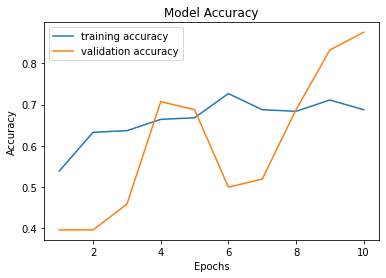

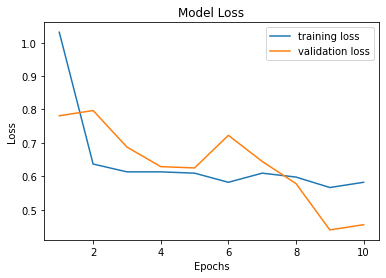

In [ ]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epochs")
x = [1, 2, 3, 4, 5, 6,7,8,9,10]
ax1.plot(x, train_acc, label='training accuracy')
ax1.plot(x, valid_acc, label='validation accuracy')

ax1.legend()

fig2, ax2 = plt.subplots()
ax2.set_title("Model Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax2.plot(x, train_loss, label='training loss')
ax2.plot(x, valid_loss, label='validation loss')

ax2.legend()
plt.show()